# Algeria: Comparative Economic Analysis Notebook

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
# load economic dataset
df = pd.read_csv('../../data/preprocessed/economic_indicators_dataset.csv')
df.head()

,Country,"Gross national income, Atlas method_$ billions_2024","Gross national income per capita, Atlas method_$_2024",Purchasing power parity gross national income_$ billions_2024,Purchasing power parity gross national income_per capita_$_2024,Gross domestic product_% growth_2024,Gross domestic product_per capita_% growth_2024,GDP_Growth_Gross domestic product_average annual real growth (%)_2010-2020,GDP_Growth_Gross domestic product_average annual real growth (%)_2020-2024,GDP_Growth_Agriculture_average annual real growth (%)_2010-2020,GDP_Growth_Agriculture_average annual real growth (%)_2020-2024,GDP_Growth_Industry_average annual real growth (%)_2010-2020,GDP_Growth_Industry_average annual real growth (%)_2020-2024,GDP_Growth_Manufacturing_average annual real growth (%)_2010-2020,GDP_Growth_Manufacturing_average annual real growth (%)_2020-2024,GDP_Growth_Services_average annual real growth (%)_2010-2020,GDP_Growth_Services_average annual real growth (%)_2020-2024,Structure_Value_Gross domestic product_$ billions_2015,Structure_Value_Gross domestic product_$ billions_2024,Structure_Value_Agriculture_% of GDP_2015,Structure_Value_Agriculture_% of GDP_2024,Structure_Value_Industry_% of GDP_2015,Structure_Value_Industry_% of GDP_2024,Structure_Value_Manufacturing_% of GDP_2015,Structure_Value_Manufacturing_% of GDP_2024,Structure_Value_Services_% of GDP_2015,Structure_Value_Services_% of GDP_2024,Structure_Manufacturing_Manufacturing value added_$ billions_2010,Structure_Manufacturing_Manufacturing value added_$ billions_2022,"Structure_Manufacturing_Food, beverages and tobacco_%of total_2010","Structure_Manufacturing_Food, beverages and tobacco_%of total_2022",Structure_Manufacturing_Textiles and clothing_%of total_2010,Structure_Manufacturing_Textiles and clothing_%of total_2022,Structure_Manufacturing_Machinery and transport equipment_%of total_2010,Structure_Manufacturing_Machinery and transport equipment_%of total_2022,Structure_Manufacturing_Chemicals_%of total_2010,Structure_Manufacturing_Chemicals_%of total_2022,Structure_Manufacturing_Other manufacturing_%of total_2010,Structure_Manufacturing_Other manufacturing_%of total_2022,Structure_Exports_Merchandise exports_$ millions_2015,Structure_Exports_Merchandise exports_$ millions_2023,Structure_Exports_Food_% of total_2015,Structure_Exports_Food_% of total_2023,Structure_Exports_Agricultural raw materials_% of total_2015,Structure_Exports_Agricultural raw materials_% of total_2023,Structure_Exports_Fuels_% of total_2015,Structure_Exports_Fuels_% of total_2023,Structure_Exports_Ores and metals_% of total_2015,Structure_Exports_Ores and metals_% of total_2023,Structure_Exports_Manufactures_% of total_2015,Structure_Exports_Manufactures_% of total_2023,"Unemployment_Unemployment, male (% of male labor force) (modeled ILO estimate)_2015","Unemployment_Unemployment, male (% of male labor force) (modeled ILO estimate)_2021","Unemployment_Unemployment, female (% of female labor force) (modeled ILO estimate)_2015","Unemployment_Unemployment, female (% of female labor force) (modeled ILO estimate)_2021","Unemployment_Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)_2015","Unemployment_Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)_2021","Unemployment_Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)_2015","Unemployment_Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)_2021",Unemployment_Unemployment with basic education (% of total labor force with basic education)_2015-21,Unemployment_Unemployment with intermediate education (% of total labor force with intermediate education)_2015-21,Unemployment_Unemployment with advanced education (% of total labor force with advanced education)_2015-21,Poverty_IntlLine1_International poverty lines_Population below $3.00 a day_%,Poverty_IntlLine1_International poverty lines_Population below $3.00 a

In [14]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset Shape: (266, 84)

Columns: ['Country', 'Gross national income, Atlas method_$ billions_2024', 'Gross national income per capita, Atlas method_$_2024', 'Purchasing power parity gross national income_$ billions_2024', 'Purchasing power parity gross national income_per capita_$_2024', 'Gross domestic product_% growth_2024', 'Gross domestic product_per capita_% growth_2024', 'GDP_Growth_Gross domestic product_average annual real growth (%)_2010-2020', 'GDP_Growth_Gross domestic product_average annual real growth (%)_2020-2024', 'GDP_Growth_Agriculture_average annual real growth (%)_2010-2020', 'GDP_Growth_Agriculture_average annual real growth (%)_2020-2024', 'GDP_Growth_Industry_average annual real growth (%)_2010-2020', 'GDP_Growth_Industry_average annual real growth (%)_2020-2024', 'GDP_Growth_Manufacturing_average annual real growth (%)_2010-2020', 'GDP_Growth_Manufacturing_average annual real growth (%)_2020-2024', 'GDP_Growth_Services_average annual real growth (%)_2010-2020'

# Check Algeria's data

In [18]:
algeria_data = df[df['Country'] == 'Algeria'].copy()
print("Algeria data shape:", algeria_data.shape)
print("\nAlgeria data sample:")
print(algeria_data.head())

Algeria data shape: (1, 84)

Algeria data sample:
   Country  Gross national income, Atlas method_$ billions_2024  \
2  Algeria                                            249.052     

   Gross national income per capita, Atlas method_$_2024  \
2                                             5320.0       

   Purchasing power parity gross national income_$ billions_2024  \
2                                            806.013               

   Purchasing power parity gross national income_per capita_$_2024  \
2                                            17220.0                 

   Gross domestic product_% growth_2024  \
2                                   3.3   

   Gross domestic product_per capita_% growth_2024  \
2                                          1.86552   

   GDP_Growth_Gross domestic product_average annual real growth (%)_2010-2020  \
2                                                2.3                            

   GDP_Growth_Gross domestic product_average annual real 

# 2. Method 1: Rank-Based Comparison

In [21]:
def rank_comparison(df, country='Algeria', metrics=None, top_n=10):
    """
    Compare Algeria's ranking across different metrics
    """
    if metrics is None:
        # Select numeric columns for ranking (excluding ID columns)
        metrics = df.select_dtypes(include=[np.number]).columns.tolist()
    
    results = {}
    
    for metric in metrics:
        if metric in df.columns:
            # Sort by metric (assuming higher is better)
            ranked = df[['Country', metric]].dropna().sort_values(metric, ascending=False)
            ranked['rank'] = range(1, len(ranked) + 1)
            
            # Find Algeria's rank
            algeria_rank = ranked[ranked['Country'] == country]
            if not algeria_rank.empty:
                rank_val = algeria_rank['rank'].values[0]
                metric_val = algeria_rank[metric].values[0]
                
                # Get top N countries
                top_countries = ranked.head(top_n)
                bottom_countries = ranked.tail(top_n)
                
                results[metric] = {
                    'algeria_rank': rank_val,
                    'algeria_value': metric_val,
                    'total_countries': len(ranked),
                    'top_countries': top_countries,
                    'bottom_countries': bottom_countries,
                    'percentile': (len(ranked) - rank_val) / len(ranked) * 100
                }
    
    return results

In [22]:
# Apply rank comparison
rank_results = rank_comparison(df, 'Algeria', top_n=5)

In [23]:
# Display results
for metric, result in list(rank_results.items())[:5]:  # Show first 5 metrics
    print(f"\n{'='*50}")
    print(f"Metric: {metric}")
    print(f"Algeria Rank: {result['algeria_rank']}/{result['total_countries']}")
    print(f"Algeria Value: {result['algeria_value']:.2f}")
    print(f"Percentile: {result['percentile']:.1f}%")
    print(f"\nTop 5 Countries:")
    print(result['top_countries'].to_string(index=False))
    print(f"\nBottom 5 Countries:")
    print(result['bottom_countries'].to_string(index=False))


Metric: Gross national income, Atlas method_$ billions_2024
Algeria Rank: 64/212
Algeria Value: 249.05
Percentile: 69.8%

Top 5 Countries:
            Country  Gross national income, Atlas method_$ billions_2024  rank
              World                                        109382.598282     1
        High income                                         69902.300000     2
East Asia & Pacific                                         32781.800000     3
      North America                                         30666.400000     4
Upper middle income                                         30662.400000     5

Bottom 5 Countries:
              Country  Gross national income, Atlas method_$ billions_2024  rank
Micronesia, Fed. Sts.                                             0.481160   208
     Marshall Islands                                             0.314545   209
                Nauru                                             0.254039   210
                Palau                    

# 3. Method 2: Regional Comparison

In [24]:
def regional_comparison(df, country='Algeria', region_col='region'):
    """
    Compare Algeria with countries in the same region
    """
    if region_col not in df.columns:
        print(f"Region column '{region_col}' not found in dataset")
        return None
    
    # Get Algeria's region
    algeria_region = df.loc[df['Country'] == country, region_col].values
    if len(algeria_region) == 0:
        print(f"Country '{country}' not found in dataset")
        return None
    
    algeria_region = algeria_region[0]
    
    # Get all countries in the same region
    regional_data = df[df[region_col] == algeria_region].copy()
    
    # Select numeric columns for comparison
    numeric_cols = regional_data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate regional statistics
    regional_stats = regional_data[numeric_cols].agg(['mean', 'median', 'std', 'min', 'max']).T
    regional_stats['algeria_value'] = regional_data[regional_data['Country'] == country][numeric_cols].values[0]
    
    # Calculate z-score for Algeria within region
    regional_stats['z_score'] = (regional_stats['algeria_value'] - regional_stats['mean']) / regional_stats['std']
    
    # Create summary
    summary = {
        'region': algeria_region,
        'regional_count': len(regional_data),
        'comparison_stats': regional_stats,
        'regional_data': regional_data
    }
    
    return summary

In [25]:
# Apply regional comparison
regional_result = regional_comparison(df, 'Algeria')

Region column 'region' not found in dataset


In [26]:
# Apply regional comparison
regional_result = regional_comparison(df, 'Algeria')

if regional_result:
    print(f"Region: {regional_result['region']}")
    print(f"Number of countries in region: {regional_result['regional_count']}")
    
    # Display comparison for top 5 metrics by absolute z-score
    stats_df = regional_result['comparison_stats']
    stats_df['abs_z_score'] = abs(stats_df['z_score'])
    top_metrics = stats_df.nlargest(5, 'abs_z_score')
    
    print("\nTop 5 metrics where Algeria differs most from regional average:")
    print(top_metrics[['algeria_value', 'mean', 'z_score']])


Region column 'region' not found in dataset


# 5. Method 4: Similarity Scoring

DATA QUALITY CHECK

Number of numeric columns: 83

Missing values in numeric columns for Algeria:
Total missing values: 36
Columns with missing values:
  Structure_Manufacturing_Food, beverages and tobacco_%of total_2010: 1 missing
  Structure_Manufacturing_Food, beverages and tobacco_%of total_2022: 1 missing
  Structure_Manufacturing_Textiles and clothing_%of total_2010: 1 missing
  Structure_Manufacturing_Textiles and clothing_%of total_2022: 1 missing
  Structure_Manufacturing_Machinery and transport equipment_%of total_2010: 1 missing
  Structure_Manufacturing_Machinery and transport equipment_%of total_2022: 1 missing
  Structure_Manufacturing_Chemicals_%of total_2010: 1 missing
  Structure_Manufacturing_Chemicals_%of total_2022: 1 missing
  Structure_Manufacturing_Other manufacturing_%of total_2010: 1 missing
  Structure_Manufacturing_Other manufacturing_%of total_2022: 1 missing
  Structure_Exports_Food_% of total_2023: 1 missing
  Structure_Exports_Agricultural raw materials_%

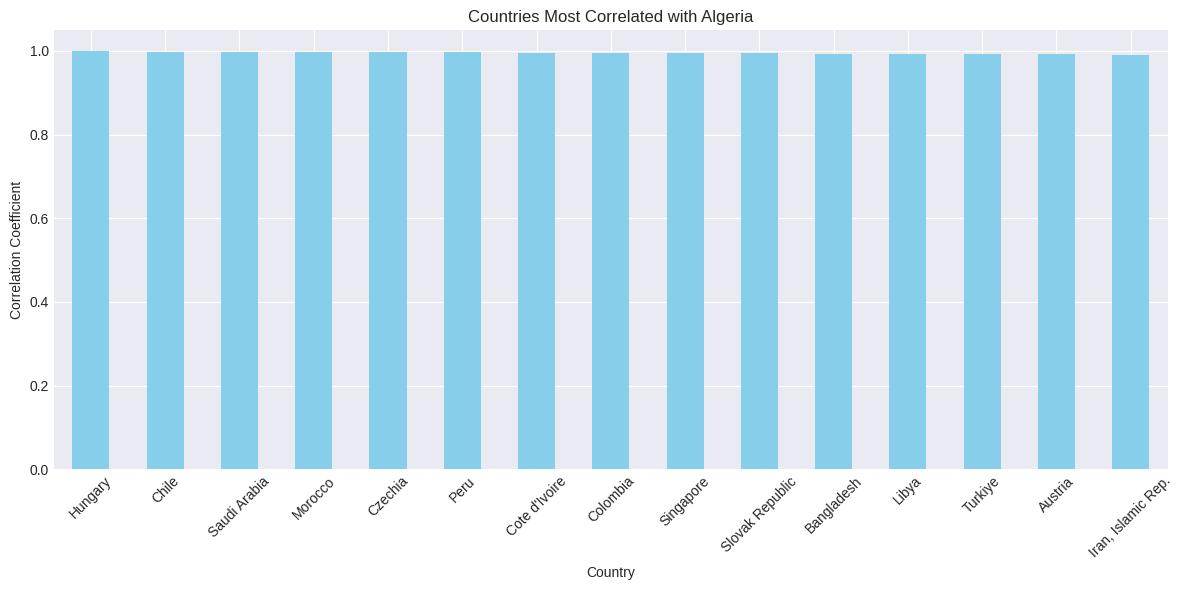

Using 10 key features: ['Gross national income, Atlas method_$ billions_2024', 'Gross national income per capita, Atlas method_$_2024', 'Purchasing power parity gross national income_$ billions_2024', 'Purchasing power parity gross national income_per capita_$_2024', 'Gross domestic product_% growth_2024', 'Gross domestic product_per capita_% growth_2024', 'GDP_Growth_Gross domestic product_average annual real growth (%)_2010-2020', 'GDP_Growth_Gross domestic product_average annual real growth (%)_2020-2024', 'GDP_Growth_Agriculture_average annual real growth (%)_2010-2020', 'GDP_Growth_Agriculture_average annual real growth (%)_2020-2024']

Top 15 similar countries to Algeria:
--------------------------------------------------
1. Peru: similarity=0.9894, distance=0.0107
2. Iran, Islamic Rep.: similarity=0.9891, distance=0.0110
3. Caribbean small states: similarity=0.9859, distance=0.0143
4. British Virgin Islands: similarity=0.9859, distance=0.0143
5. Central Europe and the Baltics: s

In [45]:
def similarity_analysis(df, country='Algeria', n_similar=10):
    """
    Find countries most similar to Algeria using multiple distance metrics
    """
    # Select numeric features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Create a copy and handle missing values
    df_clean = df[['Country'] + numeric_cols].copy()
    
    # Fill missing values with column medians
    for col in numeric_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Check if any columns have zero variance
    zero_var_cols = df_clean[numeric_cols].columns[df_clean[numeric_cols].var() == 0]
    if len(zero_var_cols) > 0:
        print(f"Warning: Removing columns with zero variance: {list(zero_var_cols)}")
        numeric_cols = [col for col in numeric_cols if col not in zero_var_cols]
    
    X = df_clean[numeric_cols].values
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Get Algeria's vector
    algeria_idx = df_clean[df_clean['Country'] == country].index
    if len(algeria_idx) == 0:
        print(f"Country '{country}' not found in cleaned data")
        return None
    
    algeria_idx = algeria_idx[0]
    algeria_vec = X_scaled[algeria_idx]
    
    # Check if Algeria's vector has any NaN values
    if np.any(np.isnan(algeria_vec)):
        print("Warning: Algeria's vector contains NaN values")
    
    # Calculate multiple similarity metrics
    similarities = []
    
    for idx in range(len(X_scaled)):
        if idx != algeria_idx:
            country_name = df_clean.iloc[idx]['Country']
            current_vec = X_scaled[idx]
            
            # Skip if current vector has NaN values
            if np.any(np.isnan(current_vec)):
                continue
            
            # Calculate Euclidean distance (handle potential issues)
            diff = algeria_vec - current_vec
            euclidean_dist = np.sqrt(np.sum(np.square(diff)))
            
            # Calculate Cosine similarity (handle zero vectors)
            algeria_norm = np.linalg.norm(algeria_vec)
            current_norm = np.linalg.norm(current_vec)
            
            if algeria_norm == 0 or current_norm == 0:
                cosine_sim = 0
            else:
                cosine_sim = np.dot(algeria_vec, current_vec) / (algeria_norm * current_norm)
            
            # Calculate Manhattan distance
            manhattan_dist = np.sum(np.abs(diff))
            
            # Combined score (avoid division by zero)
            if euclidean_dist == 0:
                combined_score = 0
            else:
                combined_score = cosine_sim / (1 + euclidean_dist)
            
            similarities.append({
                'Country': country_name,
                'euclidean_distance': euclidean_dist,
                'cosine_similarity': cosine_sim,
                'manhattan_distance': manhattan_dist,
                'combined_score': combined_score
            })
    
    if not similarities:
        print("No valid similarity scores calculated")
        return None
    
    # Create results dataframe
    sim_df = pd.DataFrame(similarities)
    
    # Rank by different metrics
    rankings = {}
    for metric in ['euclidean_distance', 'cosine_similarity', 'combined_score']:
        if metric in sim_df.columns:
            if 'distance' in metric:
                # Lower distance = more similar
                sim_df[f'{metric}_rank'] = sim_df[metric].rank(method='min')
                top_countries = sim_df.nsmallest(n_similar, metric)
            else:
                # Higher similarity = more similar
                sim_df[f'{metric}_rank'] = sim_df[metric].rank(method='min', ascending=False)
                top_countries = sim_df.nlargest(n_similar, metric)
            
            rankings[metric] = top_countries[['Country', metric, f'{metric}_rank']].copy()
    
    return {
        'similarity_df': sim_df,
        'rankings': rankings,
        'algeria_vector': algeria_vec
    }

# %% [markdown]
# ## Debug function to check data quality

# %%
def check_data_quality(df, country='Algeria'):
    """
    Check data quality before running similarity analysis
    """
    print("="*60)
    print("DATA QUALITY CHECK")
    print("="*60)
    
    # Check for country
    if country not in df['Country'].values:
        print(f"ERROR: Country '{country}' not found in dataset")
        print(f"Available countries: {df['Country'].unique()[:10]}...")
        return False
    
    # Check numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\nNumber of numeric columns: {len(numeric_cols)}")
    
    if len(numeric_cols) == 0:
        print("ERROR: No numeric columns found")
        return False
    
    # Check for missing values
    print(f"\nMissing values in numeric columns for {country}:")
    algeria_numeric = df[df['Country'] == country][numeric_cols]
    missing_counts = algeria_numeric.isnull().sum()
    total_missing = missing_counts.sum()
    print(f"Total missing values: {total_missing}")
    
    if total_missing > 0:
        print("Columns with missing values:")
        for col, count in missing_counts[missing_counts > 0].items():
            print(f"  {col}: {count} missing")
    
    # Check for zero variance columns
    print(f"\nColumns with zero variance:")
    zero_var_cols = []
    for col in numeric_cols:
        if df[col].nunique() <= 1:
            zero_var_cols.append(col)
            print(f"  {col}")
    
    if len(zero_var_cols) > 0:
        print(f"\nWARNING: {len(zero_var_cols)} columns have zero variance")
    
    # Check data ranges
    print(f"\nData ranges for {country}:")
    for col in numeric_cols[:5]:  # Show first 5
        col_data = df[col].dropna()
        if len(col_data) > 0:
            print(f"  {col}: min={col_data.min():.2f}, max={col_data.max():.2f}, mean={col_data.mean():.2f}")
    
    return True

# %%
# First check data quality
if check_data_quality(df, 'Algeria'):
    # Then run similarity analysis
    similarity_result = similarity_analysis(df, 'Algeria', n_similar=10)
    
    if similarity_result:
        print("\n" + "="*60)
        print("Top 10 Most Similar Countries to Algeria by Different Metrics:")
        print("="*60)
        
        for metric, ranking in similarity_result['rankings'].items():
            print(f"\nBy {metric.replace('_', ' ').title()}:")
            print("-" * 40)
            
            for _, row in ranking.iterrows():
                rank_value = row.get(f"{metric}_rank")
                rank_str = str(int(rank_value)) if not pd.isna(rank_value) else "-"
                metric_value = row.get(metric, 0)
                
                print(f"{rank_str}. {row['Country']}: {metric_value:.4f}")
    else:
        print("Similarity analysis failed - check the data")
else:
    print("Data quality check failed - cannot proceed with similarity analysis")

# %% [markdown]
# ## Alternative: Simple Correlation-based Similarity

# %%
def correlation_similarity(df, country='Algeria', n_similar=10):
    """
    Find similar countries using correlation-based similarity
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Create pivot table (countries as rows, features as columns)
    pivot_df = df[['Country'] + numeric_cols].set_index('Country')
    
    # Fill missing values with column means
    pivot_df = pivot_df.fillna(pivot_df.mean())
    
    # Transpose for correlation (features as rows, countries as columns)
    # This gives us country-to-country correlation
    country_corr = pivot_df.T.corr()
    
    # Get correlations with Algeria
    if country in country_corr.index:
        algeria_corr = country_corr[country].drop(country).sort_values(ascending=False)
        
        # Get top similar countries
        top_similar = algeria_corr.head(n_similar)
        
        print(f"\nTop {n_similar} countries most correlated with {country}:")
        print("-" * 50)
        for i, (country_name, corr_value) in enumerate(top_similar.items(), 1):
            print(f"{i}. {country_name}: {corr_value:.4f}")
        
        # Create visualization
        plt.figure(figsize=(12, 6))
        top_similar.plot(kind='bar', color='skyblue')
        plt.title(f'Countries Most Correlated with {country}')
        plt.xlabel('Country')
        plt.ylabel('Correlation Coefficient')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return top_similar
    else:
        print(f"Country '{country}' not found in correlation matrix")
        return None

# %%
# Try correlation-based similarity
corr_result = correlation_similarity(df, 'Algeria', n_similar=15)

# %% [markdown]
# ## Alternative: Feature-based Similarity (using selected metrics)

# %%
def feature_based_similarity(df, country='Algeria', key_features=None, n_similar=10):
    """
    Calculate similarity based on selected key features
    """
    if key_features is None:
        # Try to identify key features automatically
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Select features with reasonable variance and coverage
        key_features = []
        for col in numeric_cols:
            # Check if column has data for Algeria
            if country in df['Country'].values:
                algeria_val = df.loc[df['Country'] == country, col].values
                if len(algeria_val) > 0 and not pd.isna(algeria_val[0]):
                    # Check variance
                    col_data = df[col].dropna()
                    if len(col_data) > 10 and col_data.std() > 0:
                        key_features.append(col)
            
            # Limit to 10 features
            if len(key_features) >= 10:
                break
    
    print(f"Using {len(key_features)} key features: {key_features}")
    
    # Prepare data
    df_features = df[['Country'] + key_features].copy()
    
    # Fill missing values
    for col in key_features:
        df_features[col] = df_features[col].fillna(df_features[col].median())
    
    # Normalize features (0-1 scaling)
    normalized = df_features.copy()
    for col in key_features:
        min_val = df_features[col].min()
        max_val = df_features[col].max()
        if max_val > min_val:
            normalized[col] = (df_features[col] - min_val) / (max_val - min_val)
        else:
            normalized[col] = 0.5
    
    # Calculate simple distance (sum of absolute normalized differences)
    if country not in normalized['Country'].values:
        print(f"Country '{country}' not found in normalized data")
        return None
    
    algeria_row = normalized[normalized['Country'] == country].iloc[0]
    
    distances = []
    for idx, row in normalized.iterrows():
        if row['Country'] != country:
            # Calculate simple distance
            distance = 0
            valid_features = 0
            for col in key_features:
                if not pd.isna(row[col]) and not pd.isna(algeria_row[col]):
                    distance += abs(row[col] - algeria_row[col])
                    valid_features += 1
            
            if valid_features > 0:
                avg_distance = distance / valid_features
                distances.append({
                    'Country': row['Country'],
                    'distance': avg_distance,
                    'similarity': 1 / (1 + avg_distance)  # Convert to similarity score
                })
    
    # Sort by similarity
    distances_df = pd.DataFrame(distances)
    if len(distances_df) > 0:
        distances_df = distances_df.sort_values('similarity', ascending=False)
        
        print(f"\nTop {min(n_similar, len(distances_df))} similar countries to {country}:")
        print("-" * 50)
        for i, (_, row) in enumerate(distances_df.head(n_similar).iterrows(), 1):
            print(f"{i}. {row['Country']}: similarity={row['similarity']:.4f}, distance={row['distance']:.4f}")
        
        return distances_df
    
    return None

# %%
# Try feature-based similarity
similarity_result = feature_based_similarity(df, 'Algeria', n_similar=15)

In [35]:
print("Top 10 Most Similar Countries to Algeria by Different Metrics:")
print("\n" + "="*60)

for metric, ranking in similarity_result['rankings'].items():
    print(f"\nBy {metric.replace('_', ' ').title()}:")
    print("-" * 40)

    for _, row in ranking.iterrows():
        rank_value = row.get(f"{metric}_rank")
        rank_str = "-" if pd.isna(rank_value) else str(int(rank_value))

        print(f"{rank_str}. {row['Country']}: {row[metric]:.4f}")


Top 10 Most Similar Countries to Algeria by Different Metrics:


By Euclidean Distance:
----------------------------------------
-. Afghanistan: nan
-. Albania: nan
-. American Samoa: nan
-. Andorra: nan
-. Angola: nan
-. Antigua and Barbuda: nan
-. Arab World: nan
-. Argentina: nan
-. Armenia: nan
-. Aruba: nan

By Cosine Similarity:
----------------------------------------
-. Afghanistan: nan
-. Albania: nan
-. American Samoa: nan
-. Andorra: nan
-. Angola: nan
-. Antigua and Barbuda: nan
-. Arab World: nan
-. Argentina: nan
-. Armenia: nan
-. Aruba: nan

By Combined Score:
----------------------------------------
-. Afghanistan: nan
-. Albania: nan
-. American Samoa: nan
-. Andorra: nan
-. Angola: nan
-. Antigua and Barbuda: nan
-. Arab World: nan
-. Argentina: nan
-. Armenia: nan
-. Aruba: nan


# 6. Method 5: Gap Analysis

In [37]:
def gap_analysis(df, country='Algeria', benchmark_countries=None):
    """
    Analyze gaps between Algeria and benchmark countries
    """
    if benchmark_countries is None:
        # Default benchmarks: regional average, global average, and top performers
        benchmark_countries = {
            'Regional Avg': None,
            'Global Avg': None,
            'Top Performer': None,
            'Median Country': None
        }
    
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Get Algeria's values
    algeria_values = df[df['Country'] == country][numeric_cols].iloc[0]
    
    # Calculate benchmarks
    benchmarks = {}
    
    # Global average
    benchmarks['Global Avg'] = df[numeric_cols].mean()
    
    # Top performer (maximum value for each metric)
    benchmarks['Top Performer'] = df[numeric_cols].max()
    
    # Median country (median value for each metric)
    benchmarks['Median Country'] = df[numeric_cols].median()
    
    # Calculate gaps
    gap_results = {}
    for benchmark_name, benchmark_values in benchmarks.items():
        gaps = {}
        for col in numeric_cols:
            if pd.notna(algeria_values[col]) and pd.notna(benchmark_values[col]):
                # Calculate percentage gap
                if benchmark_values[col] != 0:
                    pct_gap = ((algeria_values[col] - benchmark_values[col]) / 
                              abs(benchmark_values[col])) * 100
                else:
                    pct_gap = np.nan
                
                # Calculate absolute gap
                abs_gap = algeria_values[col] - benchmark_values[col]
                
                gaps[col] = {
                    'algeria_value': algeria_values[col],
                    'benchmark_value': benchmark_values[col],
                    'absolute_gap': abs_gap,
                    'percentage_gap': pct_gap
                }
        
        gap_results[benchmark_name] = pd.DataFrame(gaps).T
    
    return {
        'gap_analysis': gap_results,
        'algeria_values': algeria_values
    }


In [38]:
# Apply gap analysis
gap_result = gap_analysis(df, 'Algeria')

In [39]:
# Display largest gaps
print("Largest Gaps Between Algeria and Benchmarks:")
print("="*70)

for benchmark, gaps_df in gap_result['gap_analysis'].items():
    print(f"\nCompared to {benchmark}:")
    print("-" * 40)
    
    # Sort by absolute percentage gap
    sorted_gaps = gaps_df['percentage_gap'].abs().sort_values(ascending=False).head(5)
    
    for metric in sorted_gaps.index:
        gap_info = gaps_df.loc[metric]
        direction = "above" if gap_info['percentage_gap'] > 0 else "below"
        print(f"{metric}: {gap_info['percentage_gap']:+.1f}% {direction} benchmark")
        print(f"  Algeria: {gap_info['algeria_value']:.2f}, Benchmark: {gap_info['benchmark_value']:.2f}")


Largest Gaps Between Algeria and Benchmarks:

Compared to Global Avg:
----------------------------------------
Structure_Exports_Fuels_% of total_2015: +559.0% above benchmark
  Algeria: 95.80, Benchmark: 14.54
GDP_Growth_Manufacturing_average annual real growth (%)_2020-2024: +199.2% above benchmark
  Algeria: 7.70, Benchmark: 2.57
Unemployment_Unemployment, female (% of female labor force) (modeled ILO estimate)_2021: +157.5% above benchmark
  Algeria: 23.35, Benchmark: 9.07
Unemployment_Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)_2021: +154.6% above benchmark
  Algeria: 51.12, Benchmark: 20.08
GDP_Growth_Agriculture_average annual real growth (%)_2020-2024: +141.5% above benchmark
  Algeria: 2.20, Benchmark: 0.91

Compared to Top Performer:
----------------------------------------
Poverty_IntlLine1_International poverty lines_Population below $3.00 a day_%.1: -100.0% below benchmark
  Algeria: 0.00, Benchmark: 85.30
Structure_Exports_Agricu

# 7. Method 6: Radar Chart Comparison

In [40]:
def create_radar_chart(df, country='Algeria', comparison_countries=None, metrics=None):
    """
    Create radar chart for visual comparison
    """
    if metrics is None:
        metrics = df.select_dtypes(include=[np.number]).columns.tolist()[:8]  # First 8 metrics
    
    if comparison_countries is None:
        # Select some diverse countries for comparison
        comparison_countries = ['United States', 'China', 'Brazil', 'Nigeria', 'Germany']
    
    # Prepare data
    countries_to_plot = [country] + comparison_countries
    plot_data = df[df['Country'].isin(countries_to_plot)][['Country'] + metrics]
    
    # Normalize data for radar chart (0-1 scale)
    normalized_data = plot_data.copy()
    for metric in metrics:
        min_val = df[metric].min()
        max_val = df[metric].max()
        if max_val > min_val:
            normalized_data[metric] = (plot_data[metric] - min_val) / (max_val - min_val)
        else:
            normalized_data[metric] = 0.5
    
    # Create radar chart
    categories = metrics
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(countries_to_plot)))
    
    for idx, (country_name, color) in enumerate(zip(countries_to_plot, colors)):
        values = normalized_data[normalized_data['Country'] == country_name][metrics].values[0].tolist()
        values += values[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=country_name, color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticklabels([])
    ax.set_title(f'Comparison: {country} vs Other Countries', size=15, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.show()
    
    return normalized_data


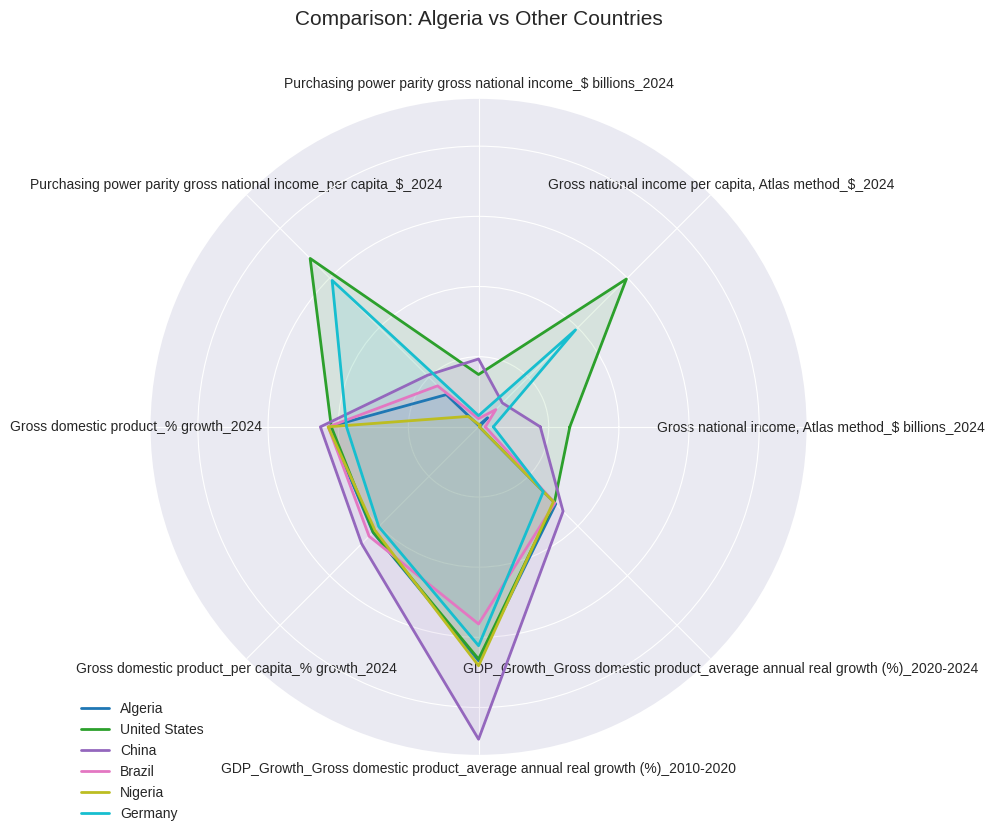

In [41]:
# Create radar chart
radar_data = create_radar_chart(df, 'Algeria')